In [64]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import shapefile as shp
import urllib, geojson, gdal, subprocess
import json
import requests
import folium
import datetime
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder
from bokeh.models import ColumnDataSource,FactorRange
from bokeh.plotting import figure
from bokeh.io import output_file, show
from bokeh.io import output_notebook
from bokeh.models import Legend
from bokeh.palettes import Spectral6
from bokeh.transform import factor_cmap
from bokeh.palettes import Category20_14 as palette
from bokeh.palettes import Category20b_14 as palette2
import itertools
from bokeh.models.tools import HoverTool

sns.set(style= 'whitegrid', palette='pastel', color_codes=True)
sns.mpl.rc('figure', figsize=(10,6))
# Set a plot style for nice plots.
plt.style.use('ggplot')

# Magic command useful jupyter notebook
%matplotlib inline

#Set plot size.
plt.rcParams['figure.figsize'] = [13,7]

#Set font size
plt.rcParams.update({'font.size':16})

Link to the website where the motor vehicle data was found [Crash Data](https://data.cityofnewyork.us/Public-Safety/Motor-Vehicle-Collisions-Crashes/h9gi-nx95), [Vehicle Data](https://data.cityofnewyork.us/Public-Safety/Motor-Vehicle-Collisions-Vehicles/bm4k-52h4) and [Persons Data](https://data.cityofnewyork.us/Public-Safety/Motor-Vehicle-Collisions-Person/f55k-p6yu)

In [156]:
df_crash = pd.read_csv('crash_clean.csv')
df_vehicle = pd.read_csv('vehicle_clean.csv')
df_persons = pd.read_csv('people_clean.csv')

C:\Users\Anders\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (8,9) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [157]:
df_crash['CRASH DATE'] = pd.to_datetime(df_crash['CRASH DATE'],errors='coerce')
df_crash['CRASH TIME'] = pd.to_datetime(df_crash['CRASH TIME'],errors='coerce')

In [158]:
df_crash.head()

,Unnamed: 0,CRASH DATE,CRASH TIME,BOROUGH,LATITUDE,LONGITUDE,ON STREET NAME,CROSS STREET NAME,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,...,NUMBER OF PEDESTRIANS KILLED,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,NUMBER OF MOTORIST INJURED,NUMBER OF MOTORIST KILLED,CONTRIBUTING FACTOR VEHICLE 1,CONTRIBUTING FACTOR VEHICLE 2,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2
0,1,2016-06-01,2020-04-22 13:54:00,QUEENS,40.655834,-73.839035,CROSS BAY BOULEVARD,161 AVENUE,0,0,...,0,0,0,0,0,Driver Inattention/Distraction,Driver Inattention/Distraction,3453947,PASSENGER VEHICLE,PASSENGER VEHICLE
1,4,2016-06-03,2020-04-22 17:15:00,QUEENS,40.665558,-73.729850,HOOK CREEK BOULEVARD,SUNRISE HIGHWAY,0,0,...,0,0,0,0,0,Unspecified,Unspecified,3455499,PASSENGER VEHICLE,PASSENGER VEHICLE
2,7,2016-05-12,2020-04-22 03:35:00,MANHATTAN,40.738316,-73.987730,EAST 20 STREET,PARK AVENUE SOUTH,2,0,...,0,0,0,2,0,Traffic Control Disregarded,Unspecified,3439699,PASSENGER VEHICLE,PASSENGER VEHICLE
3,14,2016-05-18,2020-04-22 21:15:00,QUEENS,40.768906,-73.736960,NORTHERN BOULEVARD,CORNELL LANE,0,0,...,0,0,0,0,0,Driver Inattention/Distraction,Unspecified,3452101,PASSENGER VEHICLE,PASSENGER VEHICLE
4,17,2016-05-24,2020-04-22 09:03:00,STATEN ISLAND,40.562130,-74.118190,HYLAN BOULEVARD,OAK AVENUE,0,0,...,0,0,0,0,0,Driver Inattention/Distraction,Unspecified,3452710,PASSENGER VEHICLE,PASSENGER VEHICLE


In [159]:
pd.set_option('display.max_rows', 500)

In [160]:
df_crash['VEHICLE TYPE CODE 1'] = df_crash['VEHICLE TYPE CODE 1'].str.replace('TAXI','Taxi')
df_crash['VEHICLE TYPE CODE 1'] = df_crash['VEHICLE TYPE CODE 1'].str.replace('SPORT UTILITY / STATION WAGON','Station Wagon')
df_crash['VEHICLE TYPE CODE 1'] = df_crash['VEHICLE TYPE CODE 1'].str.replace('Station Wagon/Sport Utility Vehicle','Station Wagon')
df_crash['VEHICLE TYPE CODE 1'] = df_crash['VEHICLE TYPE CODE 1'].str.replace('4 dr sedan','Sedan')
df_crash['VEHICLE TYPE CODE 1'] = df_crash['VEHICLE TYPE CODE 1'].str.replace('2 dr sedan','Sedan')
df_crash['VEHICLE TYPE CODE 1'] = df_crash['VEHICLE TYPE CODE 1'].str.replace('VAN','Van')
df_crash['VEHICLE TYPE CODE 1'] = df_crash['VEHICLE TYPE CODE 1'].str.replace('van','Van')
df_crash['VEHICLE TYPE CODE 1'] = df_crash['VEHICLE TYPE CODE 1'].str.replace('VN','Van')
df_crash['VEHICLE TYPE CODE 1'] = df_crash['VEHICLE TYPE CODE 1'].str.replace('MOTORCYCLE','Motorcycle')
df_crash['VEHICLE TYPE CODE 1'] = df_crash['VEHICLE TYPE CODE 1'].str.replace('Motorbike','Motorcycle')
df_crash['VEHICLE TYPE CODE 1'] = df_crash['VEHICLE TYPE CODE 1'].str.replace('ambul','Ambulance')
df_crash['VEHICLE TYPE CODE 1'] = df_crash['VEHICLE TYPE CODE 1'].str.replace('Ambul','Ambulance')
df_crash['VEHICLE TYPE CODE 1'] = df_crash['VEHICLE TYPE CODE 1'].str.replace('AMBUL','Ambulance')
df_crash['VEHICLE TYPE CODE 1'] = df_crash['VEHICLE TYPE CODE 1'].str.replace('AmbulanceANCE','Ambulance')
df_crash['VEHICLE TYPE CODE 1'] = df_crash['VEHICLE TYPE CODE 1'].str.replace('Ambulanceance','Ambulance')
df_crash['VEHICLE TYPE CODE 1'] = df_crash['VEHICLE TYPE CODE 1'].str.replace('AM','Ambulance')
df_crash['VEHICLE TYPE CODE 1'] = df_crash['VEHICLE TYPE CODE 1'].str.replace('Fire','Firetruck')
df_crash['VEHICLE TYPE CODE 1'] = df_crash['VEHICLE TYPE CODE 1'].str.replace('FIRE','Firetruck')
df_crash['VEHICLE TYPE CODE 1'] = df_crash['VEHICLE TYPE CODE 1'].str.replace('FIRE TRUCK','Firetruck') 
df_crash['VEHICLE TYPE CODE 1'] = df_crash['VEHICLE TYPE CODE 1'].str.replace('Firetruck TRUCK','Firetruck')
df_crash['VEHICLE TYPE CODE 1'] = df_crash['VEHICLE TYPE CODE 1'].str.replace('BUS','Bus')
df_crash['VEHICLE TYPE CODE 1'] = df_crash['VEHICLE TYPE CODE 1'].str.replace('BU','Bus')
df_crash['VEHICLE TYPE CODE 1'] = df_crash['VEHICLE TYPE CODE 1'].str.replace('BICYCLE','Bicycle')
df_crash['VEHICLE TYPE CODE 1'] = df_crash['VEHICLE TYPE CODE 1'].str.replace('Bike','Bicycle')
df_crash['VEHICLE TYPE CODE 1'] = df_crash['VEHICLE TYPE CODE 1'].str.replace('PICK-UP TRUCK','Pick-up Truck')
df_crash['VEHICLE TYPE CODE 1'] = df_crash['VEHICLE TYPE CODE 1'].str.replace('TK','Pick-up Truck')
df_crash['VEHICLE TYPE CODE 1'] = df_crash['VEHICLE TYPE CODE 1'].str.replace('LIVERY VEHICLE','Livery Vehicle')

In [124]:
df_crash.groupby(df_crash['VEHICLE TYPE CODE 1']).size().sort_values(ascending=False)

VEHICLE TYPE CODE 1
PASSENGER VEHICLE                         417664
Station Wagon                             242243
Sedan                                      75098
Taxi                                       44453
Van                                        22461
UNKNOWN                                    19287
Pick-up Truck                              18580
OTHER                                      18116
Bus                                        16434
SMALL COM VEH(4 TIRES)                     10984
LARGE COM VEH(6 OR MORE TIRES)              9974
Livery Vehicle                              8531
Bicycle                                     4976
Motorcycle                                  4779
Box Truck                                   3488
Ambulance                                   2644
Tractor Truck Diesel                        1150
Firetruck                                    732
Dump                                         535
Convertible                                  525


In [70]:
df_crash.groupby(df_crash['BOROUGH']).size().sort_values(ascending=False)

BOROUGH
BROOKLYN         285330
QUEENS           250889
MANHATTAN        225728
BRONX            124371
STATEN ISLAND     41355
dtype: int64

In [71]:
df_crash.groupby(df_crash['CONTRIBUTING FACTOR VEHICLE 1']).size().sort_values(ascending=False)

CONTRIBUTING FACTOR VEHICLE 1
Unspecified                                              395502
Driver Inattention/Distraction                           155615
Failure to Yield Right-of-Way                             61778
Other Vehicular                                           30810
Backing Unsafely                                          30055
Following Too Closely                                     26260
Fatigued/Drowsy                                           24961
Turning Improperly                                        23565
Passing or Lane Usage Improper                            16279
Traffic Control Disregarded                               16169
Lost Consciousness                                        15035
Passing Too Closely                                       13367
Driver Inexperience                                       13003
Prescription Medication                                   12717
Unsafe Lane Changing                                      10553
Pavement S

In [161]:
focusviolations = set(df_crash.groupby(df_crash['CONTRIBUTING FACTOR VEHICLE 1']).size().sort_values(ascending=False).index.to_list()[1:15])

In [162]:
focusvehicles = set(df_crash.groupby(df_crash['VEHICLE TYPE CODE 1']).size().sort_values(ascending=False).index.to_list()[1:16])

## Bokeh plots #1
In the plots below, the crashes during the **hours of the day** are plotted for different contributing factors and vehicle types.

In [163]:
df_hourlycrash = df_crash[['CONTRIBUTING FACTOR VEHICLE 1','CRASH TIME','COLLISION_ID']]
df_hourlycrash_vehicle = df_crash[['VEHICLE TYPE CODE 1','CRASH TIME','COLLISION_ID']]
df_hourlycrash['CRASH TIME'] = df_crash['CRASH TIME'].dt.hour
df_hourlycrash_vehicle['CRASH TIME'] = df_crash['CRASH TIME'].dt.hour

C:\Users\Anders\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Anders\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [164]:
df_hourlycrash = pd.pivot_table(df_hourlycrash,values = 'COLLISION_ID',index = ['CRASH TIME'],columns = ['CONTRIBUTING FACTOR VEHICLE 1'],aggfunc = 'count').fillna(0)
df_hourlycrash_vehicle = pd.pivot_table(df_hourlycrash_vehicle,values = 'COLLISION_ID',index = ['CRASH TIME'],columns = ['VEHICLE TYPE CODE 1'],aggfunc = 'count').fillna(0)

In [165]:
Total = df_crash.groupby('CONTRIBUTING FACTOR VEHICLE 1').size()
Total_vehicle = df_crash.groupby('VEHICLE TYPE CODE 1').size()

In [166]:
df_hourlycrash = df_hourlycrash.div(Total,axis=1)
df_hourlycrash_vehicle = df_hourlycrash_vehicle.div(Total_vehicle,axis=1)

In [167]:
source = ColumnDataSource(df_hourlycrash)
source_vehicle = ColumnDataSource(df_hourlycrash_vehicle)
hours = [str(elem+1) for elem in df_hourlycrash.index.to_list()]
color = itertools.cycle(palette)

In [168]:
output_notebook()

Loading BokehJS ...

In [169]:
p = figure(x_range = FactorRange(factors=hours), plot_height=500,plot_width=900, title="Crashes per hour")
bar ={} # to store vbars
items = []
for indx,i in enumerate(zip(focusviolations,color)):
    bar[i[0]] = p.vbar(x='CRASH TIME',  top=i[0], source= source,color=i[1], width = 0.5,  muted_alpha=False, muted = True)
    items.append((i[0],[bar[i[0]]]))
p.xaxis.axis_label = 'Hour of the day'
p.yaxis.axis_label = 'Normalized values'
legend = Legend(items=items,click_policy = 'mute', location=(0, 20))
p.add_layout(legend, 'left')

show(p)

In [170]:
p = figure(x_range = FactorRange(factors=hours), plot_height=500,plot_width=900, title="Crashes per hour")
bar ={} # to store vbars
items = []
for indx,i in enumerate(zip(focusvehicles,color)):
    bar[i[0]] = p.vbar(x='CRASH TIME',  top=i[0], source= source_vehicle,color=i[1], width = 0.5,  muted_alpha=False, muted = True)
    items.append((i[0],[bar[i[0]]]))
p.xaxis.axis_label = 'Hour of the day'
p.yaxis.axis_label = 'Normalized values'
legend = Legend(items=items,click_policy = 'mute', location=(0, 20))
p.add_layout(legend, 'left')

show(p)

In the plots below, the crashes during the **days of the week** are plotted for different contributing factors and vehicle types.

In [180]:
df_weeklycrash = df_crash[['CONTRIBUTING FACTOR VEHICLE 1','CRASH DATE','COLLISION_ID']]
df_weeklycrash_vehicle = df_crash[['VEHICLE TYPE CODE 1','CRASH DATE','COLLISION_ID']]
df_weeklycrash['CRASH DATE'] = df_crash['CRASH DATE'].dt.dayofweek
df_weeklycrash_vehicle['CRASH DATE'] = df_crash['CRASH DATE'].dt.dayofweek

C:\Users\Anders\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Anders\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [182]:
df_weeklycrash = pd.pivot_table(df_weeklycrash,values = 'COLLISION_ID',index = ['CRASH DATE'],columns = ['CONTRIBUTING FACTOR VEHICLE 1'],aggfunc = 'count').fillna(0)
df_weeklycrash_vehicle = pd.pivot_table(df_weeklycrash_vehicle,values = 'COLLISION_ID',index = ['CRASH DATE'],columns = ['VEHICLE TYPE CODE 1'],aggfunc = 'count').fillna(0)

In [183]:
Total = df_crash.groupby('CONTRIBUTING FACTOR VEHICLE 1').size()
Total_vehicle = df_crash.groupby('VEHICLE TYPE CODE 1').size()

In [184]:
df_weeklycrash = df_weeklycrash.div(Total,axis=1)
df_weeklycrash_vehicle = df_weeklycrash_vehicle.div(Total_vehicle,axis=1)

In [186]:
source = ColumnDataSource(df_weeklycrash)
source_vehicle = ColumnDataSource(df_weeklycrash_vehicle)
hours = [str(elem+1) for elem in df_weeklycrash.index.to_list()]
color = itertools.cycle(palette)

In [187]:
output_notebook()

Loading BokehJS ...

In [188]:
p = figure(x_range = FactorRange(factors=hours), plot_height=500,plot_width=900, title="Crashes each day")
bar ={} # to store vbars
items = []
for indx,i in enumerate(zip(focusviolations,color)):
    bar[i[0]] = p.vbar(x='CRASH DATE',  top=i[0], source= source,color=i[1], width = 0.5,  muted_alpha=False, muted = True)
    items.append((i[0],[bar[i[0]]]))
p.xaxis.axis_label = 'Day of the week'
p.yaxis.axis_label = 'Normalized values'
legend = Legend(items=items,click_policy = 'mute', location=(0, 20))
p.add_layout(legend, 'left')

show(p)

In [189]:
p = figure(x_range = FactorRange(factors=hours), plot_height=500,plot_width=900, title="Crashes each day")
bar ={} # to store vbars
items = []
for indx,i in enumerate(zip(focusvehicles,color)):
    bar[i[0]] = p.vbar(x='CRASH DATE',  top=i[0], source= source_vehicle,color=i[1], width = 0.5,  muted_alpha=False, muted = True)
    items.append((i[0],[bar[i[0]]]))
p.xaxis.axis_label = 'Day of the week'
p.yaxis.axis_label = 'Normalized values'
legend = Legend(items=items,click_policy = 'mute', location=(0, 20))
p.add_layout(legend, 'left')

show(p)

In the plots below, the crashes during the **months of the year** are plotted for different contributing factors and vehicle types.

In [190]:
df_monthlycrash = df_crash[['CONTRIBUTING FACTOR VEHICLE 1','CRASH DATE','COLLISION_ID']]
df_monthlycrash_vehicle = df_crash[['VEHICLE TYPE CODE 1','CRASH DATE','COLLISION_ID']]
df_monthlycrash['CRASH DATE'] = df_crash['CRASH DATE'].dt.month
df_monthlycrash_vehicle['CRASH DATE'] = df_crash['CRASH DATE'].dt.month

df_monthlycrash = pd.pivot_table(df_monthlycrash,values = 'COLLISION_ID',index = ['CRASH DATE'],columns = ['CONTRIBUTING FACTOR VEHICLE 1'],aggfunc = 'count').fillna(0)
df_monthlycrash_vehicle = pd.pivot_table(df_monthlycrash_vehicle,values = 'COLLISION_ID',index = ['CRASH DATE'],columns = ['VEHICLE TYPE CODE 1'],aggfunc = 'count').fillna(0)

Total = df_crash.groupby('CONTRIBUTING FACTOR VEHICLE 1').size()
Total_vehicle = df_crash.groupby('VEHICLE TYPE CODE 1').size()

df_monthlycrash = df_monthlycrash.div(Total,axis=1)
df_monthlycrash_vehicle = df_monthlycrash_vehicle.div(Total_vehicle,axis=1)

source = ColumnDataSource(df_monthlycrash)
source_vehicle = ColumnDataSource(df_monthlycrash_vehicle)
hours = [str(elem+1) for elem in df_monthlycrash.index.to_list()]
color = itertools.cycle(palette)

output_notebook()

C:\Users\Anders\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Anders\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Loading BokehJS ...

In [191]:
p = figure(x_range = FactorRange(factors=hours), plot_height=500,plot_width=900, title="Crashes each month")
bar ={} # to store vbars
items = []
for indx,i in enumerate(zip(focusviolations,color)):
    bar[i[0]] = p.vbar(x='CRASH DATE',  top=i[0], source= source,color=i[1], width = 0.5,  muted_alpha=False, muted = True)
    items.append((i[0],[bar[i[0]]]))
p.xaxis.axis_label = 'Months'
p.yaxis.axis_label = 'Normalized values'
legend = Legend(items=items,click_policy = 'mute', location=(0, 20))
p.add_layout(legend, 'left')

show(p)

In [192]:
p = figure(x_range = FactorRange(factors=hours), plot_height=500,plot_width=900, title="Crashes each month")
bar ={} # to store vbars
items = []
for indx,i in enumerate(zip(focusvehicles,color)):
    bar[i[0]] = p.vbar(x='CRASH DATE',  top=i[0], source= source_vehicle,color=i[1], width = 0.5,  muted_alpha=False, muted = True)
    items.append((i[0],[bar[i[0]]]))
p.xaxis.axis_label = 'Months'
p.yaxis.axis_label = 'Normalized values'
legend = Legend(items=items,click_policy = 'mute', location=(0, 20))
p.add_layout(legend, 'left')

show(p)

## Stacked Bokeh plot
In the plots below, the crashes of each gender is plotted in a stacked bar plot

In [244]:
df_gender_sex = df_vehicle[['VEHICLE_YEAR','DRIVER_SEX','COLLISION_ID']]
df_gender_sex = df_gender_sex[df_gender_sex['COLLISION_ID'].notnull() == True].set_index('COLLISION_ID')
df_crash2 = df_crash[df_crash['COLLISION_ID'].notnull() == True].set_index('COLLISION_ID')

In [245]:
df_merged = pd.merge(df_crash2,df_gender_sex, how='inner', left_index=True, right_index=True)

In [246]:
df_sex = df_merged[df_merged['CONTRIBUTING FACTOR VEHICLE 1'].isin(focusviolations)]
df_sex1 = df_merged[df_merged['VEHICLE TYPE CODE 1'].isin(focusvehicles)]

In [247]:
df_pre = df_sex[['CONTRIBUTING FACTOR VEHICLE 1','DRIVER_SEX','BOROUGH']]
df_pre1 = df_sex1[['VEHICLE TYPE CODE 1','DRIVER_SEX','BOROUGH']]

In [248]:
df_pre = pd.pivot_table(df_pre, values='BOROUGH', index=['DRIVER_SEX'], columns=['CONTRIBUTING FACTOR VEHICLE 1'], aggfunc='count').fillna(0)
df_pre1 = pd.pivot_table(df_pre1, values='BOROUGH', index=['DRIVER_SEX'], columns=['VEHICLE TYPE CODE 1'], aggfunc='count').fillna(0)

In [249]:
total = df_sex.groupby('CONTRIBUTING FACTOR VEHICLE 1').size()
total_vehicles = df_sex1.groupby('VEHICLE TYPE CODE 1').size()

In [250]:
df_pre = df_pre.div(total,axis = 1)
df_pre.reset_index()

CONTRIBUTING FACTOR VEHICLE 1,DRIVER_SEX,Backing Unsafely,Driver Inattention/Distraction,Driver Inexperience,Failure to Yield Right-of-Way,Fatigued/Drowsy,Following Too Closely,Lost Consciousness,Other Vehicular,Passing Too Closely,Passing or Lane Usage Improper,Prescription Medication,Traffic Control Disregarded,Turning Improperly,Unsafe Lane Changing
0,F,0.089674,0.120125,0.096339,0.144659,0.002117,0.241791,0.003560,0.062727,0.161852,0.191699,0.000510,0.135772,0.100149,0.218376
1,M,0.241162,0.344634,0.253879,0.351828,0.007084,0.649752,0.011562,0.195781,0.526593,0.605653,0.001138,0.366965,0.295129,0.693417
2,U,0.669164,0.535242,0.649782,0.503514,0.990799,0.108457,0.984878,0.741492,0.311556,0.202648,0.998352,0.497263,0.604723,0.088207


In [251]:
df_pre1 = df_pre1.div(total_vehicles,axis = 1)
df_pre1.reset_index()

VEHICLE TYPE CODE 1,DRIVER_SEX,Ambulance,Bicycle,Box Truck,Bus,LARGE COM VEH(6 OR MORE TIRES),Livery Vehicle,Motorcycle,OTHER,Pick-up Truck,SMALL COM VEH(4 TIRES),Sedan,Station Wagon,Taxi,UNKNOWN,Van
0,F,0.057692,0.104044,0.092489,0.052001,0.000203,0.0,0.035881,0.001259,0.065961,0.002769,0.227287,0.107854,0.030836,0.000453,0.009902
1,M,0.177350,0.588634,0.731007,0.184836,0.003807,0.0,0.231234,0.007667,0.381530,0.021274,0.568367,0.263120,0.296960,0.002596,0.065885
2,U,0.764957,0.307322,0.176504,0.763164,0.995990,1.0,0.732885,0.991074,0.552509,0.975958,0.204345,0.629027,0.672203,0.996951,0.924212


In [268]:
gender = df_pre.index.to_list()

In [253]:
source = ColumnDataSource(df_pre)
stacks = df_pre.columns.to_list()

source1 = ColumnDataSource(df_pre1)
stacks1 = df_pre1.columns.to_list()

In [256]:
TOOLTIPS = [("Contributing Factor","$name"), ("Fraction","@$name")]
p = figure(x_range = FactorRange(factors = gender),width=850,plot_height=500, tooltips=TOOLTIPS)

In [257]:
p.vbar_stack(stackers=stacks,x = 'DRIVER_SEX',width = 0.9,source= source,color=palette2)
show(p) #displays your plot

In [264]:
TOOLTIPS = [("Vehicly Type","$name"), ("Fraction","@$name")]
p = figure(x_range = FactorRange(factors = gender),width=850,plot_height=500, tooltips=TOOLTIPS)

In [265]:
stacks1

['Ambulance',
 'Bicycle',
 'Box Truck',
 'Bus',
 'LARGE COM VEH(6 OR MORE TIRES)',
 'Livery Vehicle',
 'Motorcycle',
 'OTHER',
 'Pick-up Truck',
 'SMALL COM VEH(4 TIRES) ',
 'Sedan',
 'Station Wagon',
 'Taxi',
 'UNKNOWN',
 'Van']

In [266]:
p.vbar_stack(stackers=stacks1,x = 'DRIVER_SEX',width = 0.9,source= source1,color=palette2)
show(p) #displays your plot

ValueError: Keyword argument sequences for broadcasting must be the same length as stackers

## Bokeh plot #2

In [271]:
df_borough = df_crash[df_crash['CONTRIBUTING FACTOR VEHICLE 1'].isin(focusviolations)]

In [272]:
df_pre = df_borough[['CONTRIBUTING FACTOR VEHICLE 1','BOROUGH','COLLISION_ID']]

In [274]:
df_pre = pd.pivot_table(df_pre, values='COLLISION_ID', index=['BOROUGH'], columns=['CONTRIBUTING FACTOR VEHICLE 1'], aggfunc='count').fillna(0)

In [275]:
total = df_borough.groupby('CONTRIBUTING FACTOR VEHICLE 1').size()

In [276]:
df_pre = df_pre.div(total,axis = 1)
df_pre.reset_index()

CONTRIBUTING FACTOR VEHICLE 1,BOROUGH,Backing Unsafely,Driver Inattention/Distraction,Driver Inexperience,Failure to Yield Right-of-Way,Fatigued/Drowsy,Following Too Closely,Lost Consciousness,Other Vehicular,Passing Too Closely,Passing or Lane Usage Improper,Prescription Medication,Traffic Control Disregarded,Turning Improperly,Unsafe Lane Changing
0,BRONX,0.140875,0.115953,0.129278,0.098385,0.088939,0.129436,0.073961,0.173126,0.159722,0.130659,0.109224,0.140392,0.122597,0.146214
1,BROOKLYN,0.288571,0.256061,0.270092,0.321020,0.299187,0.292308,0.316196,0.186628,0.289070,0.274218,0.285366,0.325809,0.231318,0.228276
2,MANHATTAN,0.228681,0.269370,0.306852,0.172181,0.323064,0.212986,0.402394,0.479422,0.275006,0.280545,0.336479,0.156039,0.404201,0.392685
3,QUEENS,0.303710,0.313768,0.248712,0.365454,0.244101,0.304455,0.189425,0.127686,0.246428,0.284108,0.235905,0.331066,0.209760,0.201080
4,STATEN ISLAND,0.038163,0.044848,0.045067,0.042960,0.044710,0.060815,0.018025,0.033139,0.029775,0.030469,0.033027,0.046694,0.032124,0.031745


In [277]:
boroughs = df_pre.index.to_list()

In [278]:
source = ColumnDataSource(df_pre)
stacks = df_pre.columns.to_list()

In [279]:
TOOLTIPS = [("Contributing Factor","$name"), ("Fraction","@$name")]
p = figure(x_range = FactorRange(factors = boroughs),width=850,plot_height=500, tooltips=TOOLTIPS)

In [280]:
p.vbar_stack(stackers=stacks,x = 'BOROUGH',width = 0.9,source= source,color=palette2)
show(p) #displays your plot

In [270]:
from folium import plugins
from folium.plugins import HeatMap

map_NYC = folium.Map(location=[40.7128, -74.0060],zoom_start = 13) 

# Filter the DF for rows, then columns, then remove NaNs
mask = (df_crash['NUMBER OF PERSONS KILLED'] == np.float64(1.0)) 
df_killcrash = df_crash.loc[mask]
df_map_NYC_kill = df_killcrash[['LATITUDE', 'LONGITUDE']]
df_map_NYC_kill = df_map_NYC_kill.dropna(axis=0, subset=['LATITUDE', 'LONGITUDE'])

# List comprehension to make out list of lists
heat_data = [[row['LATITUDE'],row['LONGITUDE']] for index, row in df_map_NYC_kill.iterrows()]

# Plot it on the map
HeatMap(heat_data,radius=9,blur = 10).add_to(map_NYC)

#HeatMap(heat_dataC,radius=5).add_to(map_NYC)

# Display the map
map_NYC

C:\Users\Anders\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


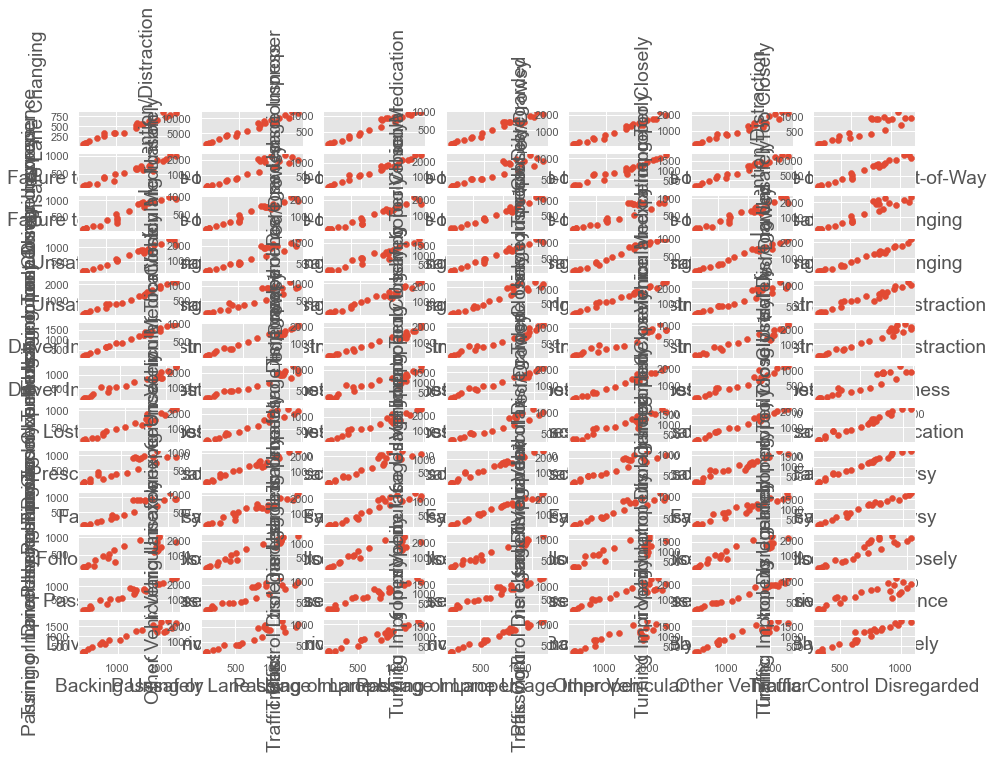

In [40]:
plt.figure(figsize=(15,10))
violations = []
idx = 1
for elem1 in focusviolations:
    for elem2 in focusviolations:
        if elem1 != elem2 and elem2 not in violations:  # 
            plt.subplot(13,7,idx)
            Main = df_crash[df_crash['CONTRIBUTING FACTOR VEHICLE 1'] == elem1]
            Comp = df_crash[df_crash['CONTRIBUTING FACTOR VEHICLE 1'] == elem2]
            x = Main.groupby(Main['CRASH TIME'].dt.hour).size().to_list()
            y = Comp.groupby(Comp['CRASH TIME'].dt.hour).size().to_list()
            plt.scatter(x,y)
            plt.xlabel(elem1)
            plt.ylabel(elem2)
            idx+=1
    violations.append(elem1)
plt.tight_layout()    
plt.show()